## This NoteBook contains the implementation of final Graph that is used for ChatSklearn Application

In [55]:
import os
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from dataclasses import dataclass, field
from typing_extensions import Annotated, Any, Literal, Optional, Union
from langchain_core.documents import Document
import uuid
import hashlib

from langchain_core.documents import Document
from langchain_core.runnables import RunnableConfig
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send
from typing_extensions import TypedDict, cast
from langchain_chroma import Chroma
from langchain_core.messages import AnyMessage
from langgraph.graph import add_messages
from typing_extensions import Any, Literal, TypedDict, cast

from langchain_core.messages import BaseMessage
from langchain_core.runnables import RunnableConfig
from langgraph.graph import END, START, StateGraph
load_dotenv()

True

In [56]:
os.environ["GEMINI_API_KEY"]=os.getenv("GOOGLE_API_KEY")

In [57]:
os.chdir('../')
!pwd

/Users/sumi/Desktop


I0000 00:00:1745577726.288491 15464160 fork_posix.cc:75] Other threads are currently calling into gRPC, skipping fork() handlers


In [58]:
embeddings=GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")
llm=ChatGoogleGenerativeAI(model="gemini-2.0-flash")

llm.invoke("Hi!")

AIMessage(content='Hi there! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run-e5008d3f-fe88-4896-b326-9fd1cef526b7-0', usage_metadata={'input_tokens': 2, 'output_tokens': 11, 'total_tokens': 13, 'input_token_details': {'cache_read': 0}})

## 1. State Schemas of ResearcherGraph

In [59]:
def _generate_uuid(page_content: str) -> str:
    """Generate a UUID for a document based on page content."""
    md5_hash = hashlib.md5(page_content.encode()).hexdigest()
    return str(uuid.UUID(md5_hash))


def reduce_docs(
    existing: Optional[list[Document]],
    new: Union[
        list[Document],
        list[dict[str, Any]],
        list[str],
        str,
        Literal["delete"],
    ],
) -> list[Document]:
    """Reduce and process documents based on the input type.

    This function handles various input types and converts them into a sequence of Document objects.
    It can delete existing documents, create new ones from strings or dictionaries, or return the existing documents.
    It also combines existing documents with the new one based on the document ID.

    Args:
        existing (Optional[Sequence[Document]]): The existing docs in the state, if any.
        new (Union[Sequence[Document], Sequence[dict[str, Any]], Sequence[str], str, Literal["delete"]]):
            The new input to process. Can be a sequence of Documents, dictionaries, strings, a single string,
            or the literal "delete".
    """
    if new == "delete":
        return []

    existing_list = list(existing) if existing else []
    if isinstance(new, str):
        return existing_list + [
            Document(page_content=new, metadata={"uuid": _generate_uuid(new)})
        ]

    new_list = []
    if isinstance(new, list):
        existing_ids = set(doc.metadata.get("uuid") for doc in existing_list)
        for item in new:
            if isinstance(item, str):
                item_id = _generate_uuid(item)
                new_list.append(Document(page_content=item, metadata={"uuid": item_id}))
                existing_ids.add(item_id)

            elif isinstance(item, dict):
                metadata = item.get("metadata", {})
                item_id = metadata.get("uuid") or _generate_uuid(
                    item.get("page_content", "")
                )

                if item_id not in existing_ids:
                    new_list.append(
                        Document(**{**item, "metadata": {**metadata, "uuid": item_id}})
                    )
                    existing_ids.add(item_id)

            elif isinstance(item, Document):
                item_id = item.metadata.get("uuid", "")
                if not item_id:
                    item_id = _generate_uuid(item.page_content)
                    new_item = item.model_copy(deep=True)
                    new_item.metadata["uuid"] = item_id
                else:
                    new_item = item

                if item_id not in existing_ids:
                    new_list.append(new_item)
                    existing_ids.add(item_id)

    return existing_list + new_list


In [60]:
@dataclass(kw_only=True)
class QueryState:
    "Private state for the retrieve_documents node in the researcher graph"
    query: str
    
  
@dataclass(kw_only=True)
class ResearcherState:
    "State of the researcher graph"
    question: str
    queries: list[str]= field(default_factory=list) 
    documents: Annotated[list[Document], reduce_docs]=field(default_factory=list)
    

## 2. Prompt for ResearcherGraph

In [61]:
GENERATE_QUERIES_SYSTEM_PROMPT = """\
Generate 3 search queries to search for to answer the user's question. \
These search queries should be diverse in nature - do not generate \
repetitive ones."""

## 3. Nodes of ResearcherGraph

In [62]:
# Genrate queries node
async def generate_queries(
    state: ResearcherState, *, config: RunnableConfig
    )-> dict[str, list[str]]:
    """Generate search queries based on the question (a step in the research plan)."""
    
    class Response(TypedDict):
        queries: list[str]
        
    model=llm.with_structured_output(Response)
    messages=[
        {"role": "system", "content": GENERATE_QUERIES_SYSTEM_PROMPT},
        {"role": "human", "content": state.question},
    ]
    response= cast(Response, await model.ainvoke(messages))
    return {"queries": response["queries"]}


## 3.1 Creating Retriever

In [63]:
# Load the persisted directory
db = Chroma(persist_directory="DATA/chroma_store",
            embedding_function=embeddings)

# Convert it into a retriever
retriever = db.as_retriever()

In [64]:
print(db._collection.count())

28507


In [65]:
retriever.invoke("How to perform cross-validation?")

[Document(id='6ff74092-ab0e-4fe8-97b0-1be3a7dc4be2', metadata={'description': 'Choosing the right cross-validation object is a crucial part of fitting a model properly. There are many ways to split data into training and test sets in order to avoid model overfitting, to stand...', 'language': 'en', 'source': 'https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html', 'title': 'Visualizing cross-validation behavior in scikit-learn — scikit-learn 1.6.1 documentation'}, page_content='import matplotlib.pyplot as plt\nimport numpy as np\nfrom matplotlib.patches import Patch\n\nfrom sklearn.model_selection import (\n    GroupKFold,\n    GroupShuffleSplit,\n    KFold,\n    ShuffleSplit,\n    StratifiedGroupKFold,\n    StratifiedKFold,\n    StratifiedShuffleSplit,\n    TimeSeriesSplit,\n)\n\nrng = np.random.RandomState(1338)\ncmap_data = plt.cm.Paired\ncmap_cv = plt.cm.coolwarm\nn_splits = 4\n\n\n\nVisualize our data#\nFirst, we must understand the structure of our da

In [66]:
# retrieve documents node
async def retrieve_documents(
    state: QueryState, *, config: RunnableConfig
    )-> dict[str, list[Document]]:
    """Retrieve documents based on a given query."""
    
    response=await retriever.ainvoke(state.query,config)
    return {"documents": response}

In [67]:
# retrieve documents in parallel
def retrieve_in_parallel(state: ResearcherState)-> list[Send]:
    """Create parallel retrieval tasks for each generated query."""
    return [
        Send("retrieve_documents", QueryState(query=query)) for query in state.queries
    ]

## 4. ResearcherGraph definition

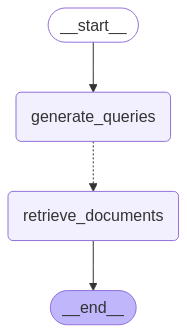

In [68]:
builder = StateGraph(ResearcherState)
builder.add_node(generate_queries)
builder.add_node(retrieve_documents)
builder.add_edge(START, "generate_queries")
builder.add_conditional_edges(
    "generate_queries",
    retrieve_in_parallel,  # type: ignore
    path_map=["retrieve_documents"],
)
builder.add_edge("retrieve_documents", END)
# Compile into a graph object that you can invoke and deploy.
researcher_graph = builder.compile()
researcher_graph.name = "ResearcherGraph"
researcher_graph

## 5. Invoking the Graph

In [69]:
state = ResearcherState(question="How to perform cross-validation?")
final_state = await researcher_graph.ainvoke(state)

final_state

/Users/sumi/miniforge3/envs/CDEnv/lib/python3.10/site-packages/langchain_google_genai/chat_models.py:1410: UserWarning: ChatGoogleGenerativeAI.with_structured_output with dict schema has changed recently to align with behavior of other LangChain chat models. More context: https://github.com/langchain-ai/langchain-google/pull/772
  warnings.warn(


{'question': 'How to perform cross-validation?',
 'queries': ['cross validation techniques',
  'cross validation implementation',
  'benefits of cross validation'],
 'documents': [Document(id='0cae92ed-da4f-4d81-80b2-1142431443ef', metadata={'description': 'Learning the parameters of a prediction function and testing it on the same data is a methodological mistake: a model that would just repeat the labels of the samples that it has just seen would ha...', 'language': 'en', 'source': 'https://scikit-learn.org/stable/modules/cross_validation.html', 'title': '3.1. Cross-validation: evaluating estimator performance — scikit-learn 1.6.1 documentation', 'uuid': 'a116f471-bf72-67c9-d3f5-a383635b7806'}, page_content='which can be used for learning the model,\nand the results can depend on a particular random choice for the pair of\n(train, validation) sets.\nA solution to this problem is a procedure called\ncross-validation\n(CV for short).\nA test set should still be held out for final evalu

## 6. State schemas for RetrirvalGraph

In [70]:
@dataclass(kw_only=True)
class InputState:
    """Represents the input state for the agent"""
    messages: Annotated[list[AnyMessage], add_messages]
    
    
class Router(TypedDict):
    """Classifu user query"""
    logic: str
    type: Literal["more-info", "scikit-learn", "general"]
    

@dataclass(kw_only=True)
class AgentState(InputState):
    """State of the retrieval graph"""
    router: Router=field(default_factory=lambda: Router(type="general", logic=""))
    steps: list[str]=field(default_factory=list)
    documents: Annotated[list[Document], reduce_docs]=field(default_factory=list)
    


## 7. Prompts for RetrievalGraph

In [71]:
ROUTER_SYSTEM_PROMPT = """You are a Scikit-learn Developer advocate. Your job is help people using Scikit-learn answer any issues they are running into.

A user will come to you with an inquiry. Your first job is to classify what type of inquiry it is. The types of inquiries you should classify it as are:

## `more-info`
Classify a user inquiry as this if you need more information before you will be able to help them. Examples include:
- The user complains about an error but doesn't provide the error
- The user says something isn't working but doesn't explain why/how it's not working

## `scikit-learn`
Classify a user inquiry as this if it can be answered by looking up information related to Scikit-learn open source package. The Scikit-learn open source package \
is a python library. It is a collection of algorithms and tools for machine learning. \

## `general`
Classify a user inquiry as this if it is just a general question"""


In [72]:
GENERAL_SYSTEM_PROMPT = """You are a Scikit-learn Developer advocate. Your job is help people using Scikit-learn answer any issues they are running into.

Your boss has determined that the user is asking a general question, not one related to Scikit-learn. This was their logic:

<logic>
{logic}
</logic>

Respond to the user. Politely decline to answer and tell them you can only answer questions about Scikit-learn related topics, and that if their question is about scikit-learn they should clarify how it is.\
Be nice to them though - they are still a user!"""


In [73]:
MORE_INFO_SYSTEM_PROMPT = """You are a Scikit-learn Developer advocate. Your job is help people using Scikit-learn answer any issues they are running into.

Your boss has determined that more information is needed before doing any research on behalf of the user. This was their logic:

<logic>
{logic}
</logic>

Respond to the user and try to get any more relevant information. Do not overwhelm them! Be nice, and only ask them a single follow up question."""



In [74]:
RESEARCH_PLAN_SYSTEM_PROMPT = """You are a Scikit-learn expert and a world-class researcher, here to assist with any and all questions or issues with Scikit-learn, Machine Learning, Data Science, or any related functionality. Users may come to you with questions or issues.

Based on the conversation below, generate a plan for how you will research the answer to their question. \
The plan should generally not be more than 3 steps long, it can be as short as one. The length of the plan depends on the question.

You have access to the following documentation sources:
- User guide
- API Reference
- Examples
- Scikit-learn documentation
- Code snippets
- Tutorials
- Conceptual docs
- Integration docs

You do not need to specify where you want to research for all steps of the plan, but it's sometimes helpful."""


In [75]:
RESPONSE_SYSTEM_PROMPT = """\
You are an expert programmer and problem-solver, tasked with answering any question precisely\
about Scikit-learn. 

Guidelines:
- Scale response length appropriately to the question complexity
- Use only information from the provided search results
- Maintain an unbiased, informative tone
- Use bullet points for readability
- Place citations [$number] immediately after relevant sentences/paragraphs
- Present code blocks exactly as they appear, using ```python and ``` formatting

When the search results don't contain relevant information:
- Acknowledge the limitations
- Explain why you're unsure
- Ask for clarifying information if helpful

Do not:
- Ramble or repeat information
- Put all citations at the end
- Make up answers not supported by the context
- Claim capabilities not evidenced in the search results
- Modify or summarize code examples

Anything between the `context` html blocks is retrieved from a knowledge bank:

<context>
    {context}
</context>
"""


## 8. Nodes of RetrievalGraph

In [76]:
# QueryAnalyzer
async def analyze_and_route_query(
    state: AgentState, *, config: RunnableConfig
)-> dict[str, Router]:
    """Analyze the user's query and determine the appropriate routing"""
    model=llm
    messages=[
        {"role": "system", "content": ROUTER_SYSTEM_PROMPT}
    ]+ state.messages
    response=cast(Router, await model.with_structured_output(Router).ainvoke(messages))
    return {"router": response}


In [77]:
# QueryRouter
def route_query(
    state: AgentState,
)-> Literal["create_research_plan", "ask_for_more_info", "respond_to_general_query"]:
    """Determine the next steps based on query classification"""
    _type=state.router["type"]
    if _type=="scikit-learn":
        return "create_research_plan"
    elif _type=="more-info":
        return "ask_for_more_info"
    elif _type=="general":
        return "respond_to_general_query"
    else:
        raise ValueError(f"Unknown router type: {_type}")
    

In [78]:
# ask_for_more_info
async def ask_for_more_info(
    state: AgentState, *, config: RunnableConfig
)-> dict[str, list[BaseMessage]]:
    """Generate a response asking the user for more information"""
    model=llm
    system_prompt=MORE_INFO_SYSTEM_PROMPT.format(logic=state.router["logic"])
    messages=[{"role": "system", "content": system_prompt}]+state.messages
    response= await model.ainvoke(messages)
    return {"messages": [response]}


In [79]:
# Respond to general query
async def respond_to_general_query(
    state: AgentState, *, config: RunnableConfig
) -> dict[str, list[BaseMessage]]:
    """Generate a response to a general query not related to scikit-learn."""
    model = llm
    system_prompt = GENERAL_SYSTEM_PROMPT.format(
        logic=state.router["logic"]
    )
    messages = [{"role": "system", "content": system_prompt}] + state.messages
    response = await model.ainvoke(messages)
    return {"messages": [response]}


In [80]:
# Create research plan
async def create_research_plan(
    state: AgentState, *, config: RunnableConfig
) -> dict[str, list[str] | str]:
    """Create a step-by-step research plan for answering a Scikit-learn related query."""

    class Plan(TypedDict):
        """Generate research plan."""

        steps: list[str]

    model = llm.with_structured_output(Plan)
    messages = [
        {"role": "system", "content": RESEARCH_PLAN_SYSTEM_PROMPT}
    ] + state.messages
    response = cast(Plan, await model.ainvoke(messages))
    return {"steps": response["steps"], "documents": "delete"}


In [81]:
# Conduct Research
async def conduct_research(state: AgentState) -> dict[str, Any]:
    """Execute the first step of the research plan."""
    result = await researcher_graph.ainvoke({"question": state.steps[0]})
    
    return {"documents": result["documents"], "steps": state.steps[1:]}


In [82]:
def check_finished(state: AgentState) -> Literal["respond", "conduct_research"]:
    """Determine if the research process is complete or if more research is needed."""
    if len(state.steps or []) > 0:
        return "conduct_research"
    else:
        return "respond"
    

In [83]:
# Modified format_doc function to preserve code blocks
def _format_doc(doc: Document) -> str:
    """Format a single document as XML with special handling for code blocks."""
    metadata = doc.metadata or {}
    meta = "".join(f" {k}={v!r}" for k, v in metadata.items())
    if meta:
        meta = f" {meta}"

    # Process the page content to preserve code blocks
    page_content = doc.page_content
    
    # Add special xml tags to mark code blocks for the LLM
    # This helps ensure the model recognizes and preserves them
    return f"<document{meta}>\n<content>\n{page_content}\n</content>\n</document>"


def format_docs(docs: Optional[list[Document]]) -> str:
    """Format a list of documents as XML.

    This function takes a list of Document objects and formats them into a single XML string.

    Args:
        docs (Optional[list[Document]]): A list of Document objects to format, or None.

    Returns:
        str: A string containing the formatted documents in XML format.
    """
    if not docs:
        return "<documents></documents>"
    
    formatted = "\n".join(_format_doc(doc) for doc in docs)
    return f"""<documents>
{formatted}
</documents>"""


In [84]:
async def respond(
    state: AgentState, *, config: RunnableConfig
) -> dict[str, list[BaseMessage]]:
    """Generate a final response to the user's query based on the conducted research."""

    model = llm
    documents=state.documents or [] ## Prepare documents with explicit code block preservation
    context = format_docs(state.documents) # Do Not Change
    prompt = RESPONSE_SYSTEM_PROMPT.format(context=context)
    messages = [{"role": "system", "content": prompt+"\n\nIMPORTANT: Always preserve code blocks with ```python and ``` markers. Never modify code content."}] + state.messages
    response = await model.ainvoke(messages)
    return {"messages": [response]}


## 9. RetrievalGraph definition

In [85]:
builder = StateGraph(AgentState, input=InputState)

builder.add_node("analyze_and_route_query",analyze_and_route_query)
builder.add_node("ask_for_more_info",ask_for_more_info)
builder.add_node("respond_to_general_query",respond_to_general_query)
builder.add_node("conduct_research",conduct_research)
builder.add_node("create_research_plan",create_research_plan)
builder.add_node("respond",respond)

builder.add_edge(START, "analyze_and_route_query")
builder.add_conditional_edges("analyze_and_route_query", route_query)
builder.add_edge("create_research_plan", "conduct_research")
builder.add_conditional_edges("conduct_research", check_finished)
builder.add_edge("ask_for_more_info", END)
builder.add_edge("respond_to_general_query", END)
builder.add_edge("respond", END)

# Compile into a graph object that you can invoke and deploy.
graph = builder.compile()
graph.name = "RetrievalGraph"


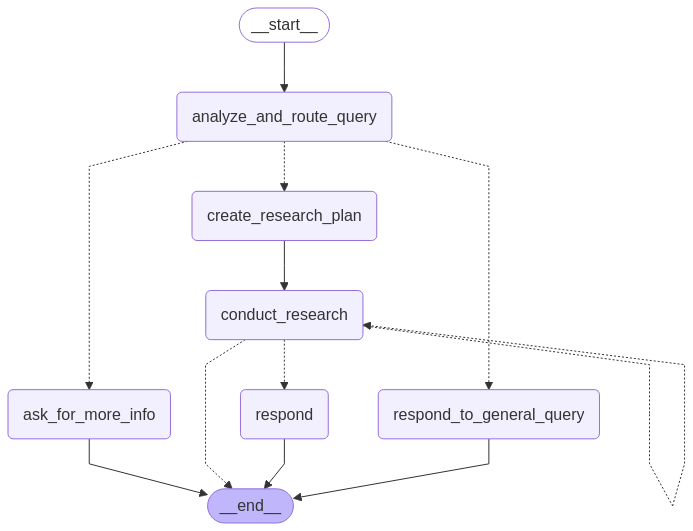

In [88]:
graph

In [86]:
from langchain_core.messages import HumanMessage

input_state = {
    "messages": [HumanMessage(content="How to use Logistic Regression?")]
}


response = await graph.ainvoke(input_state)
response

/Users/sumi/miniforge3/envs/CDEnv/lib/python3.10/site-packages/langchain_google_genai/chat_models.py:1410: UserWarning: ChatGoogleGenerativeAI.with_structured_output with dict schema has changed recently to align with behavior of other LangChain chat models. More context: https://github.com/langchain-ai/langchain-google/pull/772
  warnings.warn(
/Users/sumi/miniforge3/envs/CDEnv/lib/python3.10/site-packages/langchain_google_genai/chat_models.py:1410: UserWarning: ChatGoogleGenerativeAI.with_structured_output with dict schema has changed recently to align with behavior of other LangChain chat models. More context: https://github.com/langchain-ai/langchain-google/pull/772
  warnings.warn(
/Users/sumi/miniforge3/envs/CDEnv/lib/python3.10/site-packages/langchain_google_genai/chat_models.py:1410: UserWarning: ChatGoogleGenerativeAI.with_structured_output with dict schema has changed recently to align with behavior of other LangChain chat models. More context: https://github.com/langchain-ai

{'messages': [HumanMessage(content='How to use Logistic Regression?', additional_kwargs={}, response_metadata={}, id='30c59543-bf48-45e5-8adf-ccdc17b26027'),
  AIMessage(content="Logistic Regression in scikit-learn is a linear model used for classification tasks. It applies a logistic function to predict the probabilities of the classes [df711738-0716-97ec-aff6-ab926b26f7dc]. Here's how to use it:\n\n1.  **Import the model:**\n    ```python\n    from sklearn.linear_model import LogisticRegression\n    ```\n\n2.  **Create an instance of the model:**\n    ```python\n    logisticRegr = LogisticRegression()\n    ```\n\n3.  **Fit the model with training data:**\n    ```python\n    logisticRegr.fit(X_train, y_train)\n    ```\n    `X_train` is the training data and `y_train` contains the corresponding labels.\n\n4.  **Make predictions:**\n    ```python\n    predictions = logisticRegr.predict(X_test)\n    ```\n    `X_test` is the test data for which you want to make predictions.\n\n**Additiona

In [87]:
final_response = response["messages"][-1].content
print(final_response)

Logistic Regression in scikit-learn is a linear model used for classification tasks. It applies a logistic function to predict the probabilities of the classes [df711738-0716-97ec-aff6-ab926b26f7dc]. Here's how to use it:

1.  **Import the model:**
    ```python
    from sklearn.linear_model import LogisticRegression
    ```

2.  **Create an instance of the model:**
    ```python
    logisticRegr = LogisticRegression()
    ```

3.  **Fit the model with training data:**
    ```python
    logisticRegr.fit(X_train, y_train)
    ```
    `X_train` is the training data and `y_train` contains the corresponding labels.

4.  **Make predictions:**
    ```python
    predictions = logisticRegr.predict(X_test)
    ```
    `X_test` is the test data for which you want to make predictions.

**Additional Information:**

*   **Regularization:** Logistic Regression can be regularized using L1 or L2 penalties to prevent overfitting [5df4d0e1-fec1-608b-c5ea-9d4392a52931].
*   **Multiclass classification:**